In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import torchvision.transforms.functional as TF

In [18]:
from torch import optim
from torch.utils.data import DataLoader
from data.datasets.golden_panels import GoldenPanelsDataset
from networks.ssupervae_contextual_attentional import SSuperVAEContextualAttentional
from training.ssupervae_contextual_attn_trainer import SSuperVAEContextualAttentionalTrainer
from utils.config_utils import read_config, Config
from utils.plot_utils import *
from utils.logging_utils import *
from utils.image_utils import *
from configs.base_config import *
from functional.losses.elbo import elbo
import torch.nn as nn
from copy import deepcopy

In [37]:
config = read_config(Config.VAE_CONTEXT_ATTN)
golden_age_config = read_config(Config.GOLDEN_AGE)
ptu.set_gpu_mode(True)

In [38]:
panel_dim = golden_age_config.panel_dim[0]

In [39]:
net = SSuperVAEContextualAttentional(config.backbone,
                                         panel_img_size=panel_dim,
                                         latent_dim=config.latent_dim,
                                         embed_dim=config.embed_dim,
                                         seq_size=config.seq_size,
                                         decoder_channels=config.decoder_channels,
                                         gen_img_size=config.image_dim).cuda()

if getattr(config, 'parallel', False):
    net = nn.DataParallel(net)
    print("parallel true")
else:
    net = net
 
# 01-06-2021-15-22-42_model-checkpoint-epoch81
# 02-06-2021-12-13-54_model-checkpoint-epoch67
# 26-05-2021-13-05-56_model-checkpoint-epoch99
load_path = "/scratch/users/gsoykan20/projects/AF-GAN/playground/ssupervae_contextual_attention/ckpts/02-06-2021-12-13-54_model-checkpoint-epoch67.pth"
net.load_state_dict(torch.load(load_path)['model_state_dict'])
if getattr(config, 'parallel', False):
    print("paralled true")
    net = net.module
net = net.cuda().eval()

Loaded pretrained weights for efficientnet-b5


In [40]:
dataset = GoldenPanelsDataset(golden_age_config.panel_path,
                              golden_age_config.sequence_path, 
                              golden_age_config.panel_dim,
                              config.image_dim, 
                              augment=False, 
                              shuffle=False,
                              mask_val=1, # mask with white color for 1 and black color for 0
                              mask_all=False, # masks faces from all panels and returns all faces
                              return_mask=True,
                              return_mask_coordinates=True,
                              train_test_ratio=golden_age_config.train_test_ratio,
                              train_mode=False,
                              limit_size=-1)

dataset.data = [
    [['593/29_6.jpg', '593/30_0.jpg', '593/30_1.jpg'], [[[29, 0, 532, 503], [183, 51, 281, 149]], [[7, 0, 543, 536], [90, 229, 206, 345]], 
                                                        [[15, 0, 552, 537], [186, 192, 298, 304]]]], # animal
    
    [['3918/34_0.jpg', '3918/34_1.jpg', '3918/34_2.jpg'], [[[31, 0, 570, 539], [117, 278, 239, 400]], [[0, 14, 506, 520], [155, 181, 195, 221]],
                                                           [[18, 0, 514, 496], [121, 274, 229, 382]]]], # woman
    
    [['211/20_0.jpg', '211/20_1.jpg', '211/20_2.jpg'], [[[612, 0, 1165, 553], [1041, 188, 1105, 252]], [[20, 0, 589, 569], [386, 189, 462, 265]],
                                                        [[39, 0, 595, 556], [95, 175, 289, 369]]]], # bad man
    
    [['915/30_1.jpg', '915/30_2.jpg', '915/30_3.jpg'], [[[0, 7, 419, 426], [127, 205, 255, 333]], [[0, 59, 356, 415], [160, 258, 282, 380]],
                                                        [[0, 82, 264, 346], [89, 228, 193, 332]]]], # good man

    [['3513/21_5.jpg', '3513/21_6.jpg', '3513/22_0.jpg'], [[[59, 0, 611, 552], [199, 180, 369, 350]], [[0, 17, 533, 550], [90, 206, 164, 280]],
                                                           [[0, 69, 395, 464], [73, 230, 185, 342]]]], # good man

    [['2464/73_4.jpg', '2464/73_5.jpg', '2464/73_6.jpg'], [[[131, 0, 743, 612], [225, 206, 361, 342]], [[168, 0, 890, 722], [602, 316, 658, 372]],
                                                           [[73, 0, 740, 667], [185, 266, 331, 412]]]], # mask problem
]

data_loader = DataLoader(dataset, batch_size=1, shuffle=False)

dl_iter = iter(data_loader)

In [15]:
def create_global_pred_gt_images(
                                     x,
                                     y,
                                     mu_x,
                                     mask_coordinates):
        # Preparing for Fine Generator
        B, S, C, W, H = x.shape
        last_panel_gts = ptu.zeros(B, C, H, W)
        panel_with_generation = ptu.zeros_like(last_panel_gts)
        for i in range(len(x)):
            last_panel = x[i, -1, :, :, :]
            output_merged_last_panel = deepcopy(last_panel)

            last_panel_face = y[i, :, :, :]
            last_panel_output_face = mu_x[i, :, :, :]

            mask_coordinates_n = mask_coordinates[i]

            original_w = abs(mask_coordinates_n[0] - mask_coordinates_n[1])
            original_h = abs(mask_coordinates_n[2] - mask_coordinates_n[3])

            # inserting original face to last panel
            modified = last_panel_face.view(1, *last_panel_face.size())
            interpolated_last_panel_face_batch = torch.nn.functional.interpolate(modified,
                                                                                 size=(original_w, original_h))
            interpolated_last_panel_face = interpolated_last_panel_face_batch[0]
            last_panel[:,
            mask_coordinates_n[0]: mask_coordinates_n[1],
            mask_coordinates_n[2]: mask_coordinates_n[3]] = interpolated_last_panel_face
            last_panel_gts[i, :, :, :] = last_panel

            # inserting output face to last panel
            modified = last_panel_output_face.view(1, *last_panel_output_face.size())
            interpolated_last_panel_face_batch = torch.nn.functional.interpolate(modified,
                                                                                 size=(original_w, original_h))
            interpolated_last_panel_face = interpolated_last_panel_face_batch[0]
            output_merged_last_panel[:, mask_coordinates_n[0]: mask_coordinates_n[1],
            mask_coordinates_n[2]: mask_coordinates_n[3]] = interpolated_last_panel_face
            panel_with_generation[i, :, :, :] = output_merged_last_panel

        return panel_with_generation, last_panel_gts

In [23]:
def plot_panels_and_faces(panels_tensor, face_tensor, recon_face_tensor, global_recon_tensor):
    
    global_recon_tensor = get_PIL_image(global_recon_tensor[0,:,:,:])
    y_recon = get_PIL_image(recon_face_tensor[0,:,:,:])
    y = get_PIL_image(face_tensor[0,:,:,:])
    
    panels = []
    for i in range(panels_tensor.shape[1]):
        panels.append(get_PIL_image(panels_tensor[0,i,:,:,:]))
    
    w, h = panels[0].size
    wsize, hsize =  2, 1 # panels_tensor.shape[1] + 3, 1
    w = (w + 100) * wsize
    h = (h + 50) * hsize
    
    px = 1/plt.rcParams['figure.dpi']
    f, ax = plt.subplots(hsize, wsize)
    f.set_size_inches(w*px, h*px)
    
    #for i in range(len(panels)):
     #   ax[i].imshow(panels[i])
      #  ax[i].title.set_text("Panel" + str(i+1))
       
    ax[-2].imshow(global_recon_tensor)
    ax[-2].title.set_text("Global Recon")
    
    ax[-1].imshow(y_recon)
    ax[-1].title.set_text("Recon")
    
   # ax[-1].imshow(y)
   # ax[-1].title.set_text("Original")
    
    
    
    plt.show()
    return plt

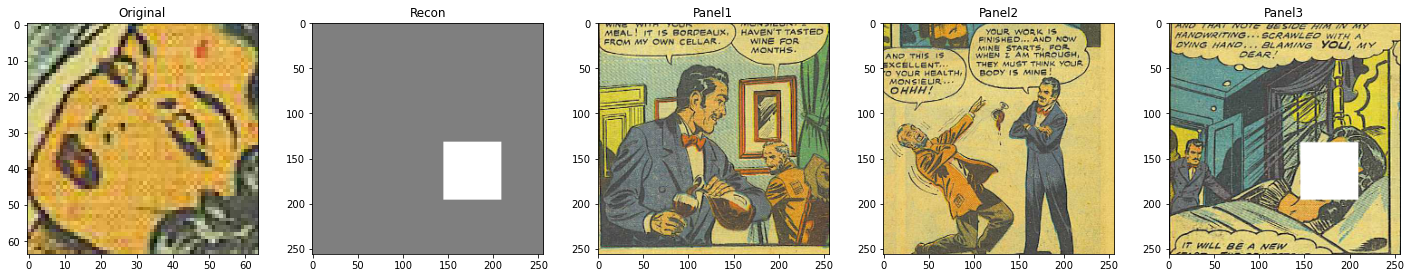

In [12]:
x, y, z, mask_coordinates = next(dl_iter)
plot_panels_and_faces(x, y, z.unsqueeze(0).repeat(1, 3, 1, 1))

In [24]:
## TEMP

In [25]:
"""
stds = torch.Tensor([0.229, 0.224, 0.225])
means = torch.Tensor([0.485, 0.456, 0.406])

def convert_to_new_augmentation(img):
    img = img * stds.view(1, 3, 1, 1).cuda() + means.view(1, 3, 1, 1).cuda()
    img *= 2
    img -= 1
    return img

def convert_to_old_augmentation(img):
    img = (img + 1) / 2
    img = TF.normalize(img, mean=means, std=stds)
    return img
"""

'\nstds = torch.Tensor([0.229, 0.224, 0.225])\nmeans = torch.Tensor([0.485, 0.456, 0.406])\n\ndef convert_to_new_augmentation(img):\n    img = img * stds.view(1, 3, 1, 1).cuda() + means.view(1, 3, 1, 1).cuda()\n    img *= 2\n    img -= 1\n    return img\n\ndef convert_to_old_augmentation(img):\n    img = (img + 1) / 2\n    img = TF.normalize(img, mean=means, std=stds)\n    return img\n'

[INFO] Coarse Example: 0


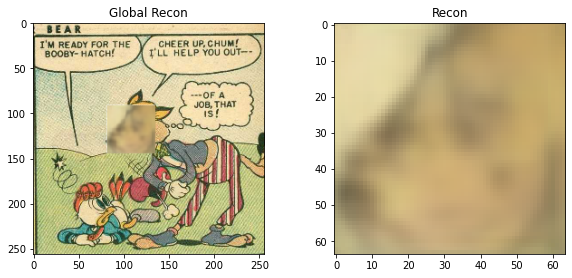

[INFO] Fine Example: 0


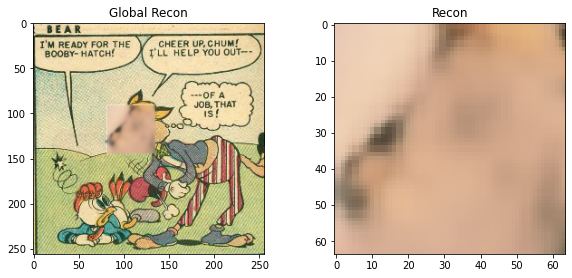

[INFO] Coarse Example: 1


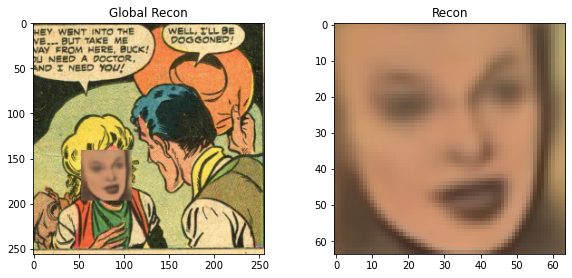

[INFO] Fine Example: 1


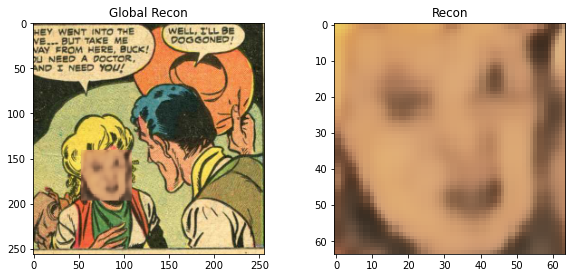

[INFO] Coarse Example: 2


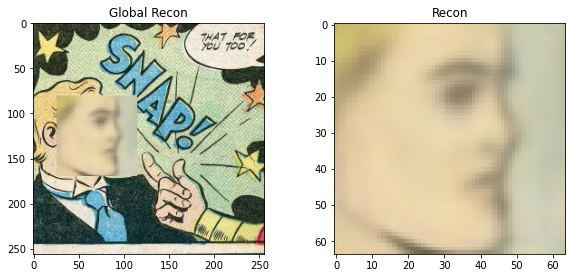

[INFO] Fine Example: 2


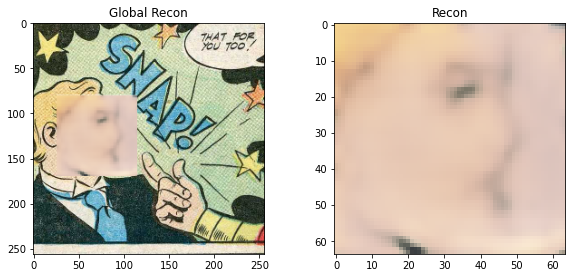

[INFO] Coarse Example: 3


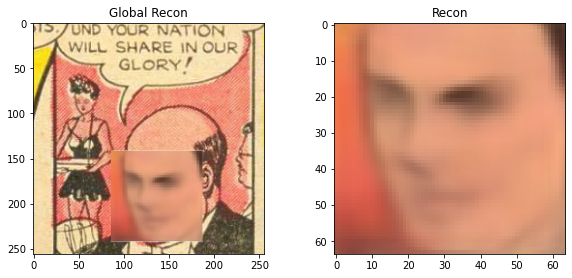

[INFO] Fine Example: 3


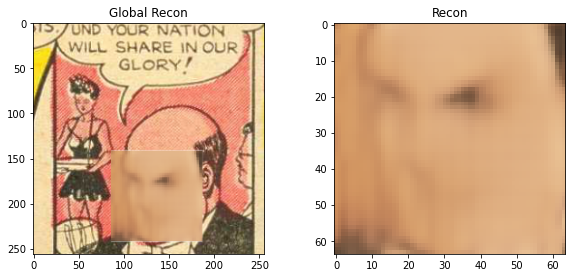

[INFO] Coarse Example: 4


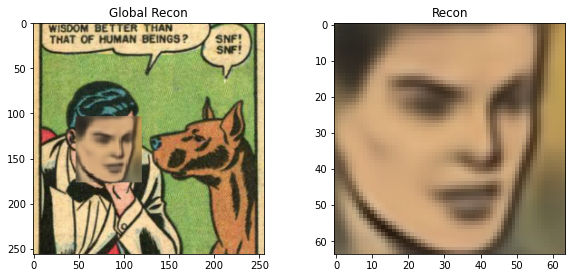

[INFO] Fine Example: 4


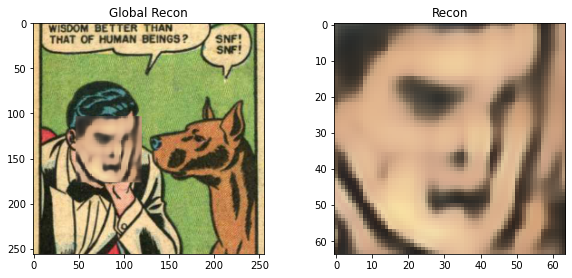

[INFO] Coarse Example: 5


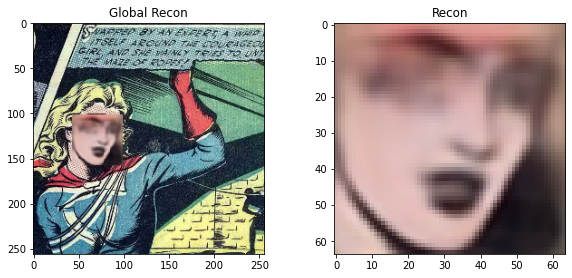

[INFO] Fine Example: 5


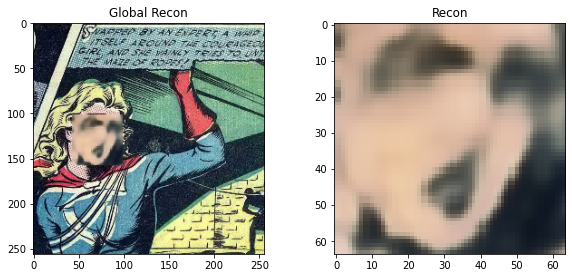

In [41]:
ctr, limit = 0, 6


for i in range(limit):
    x, y, mask, mask_coordinates = next(dl_iter)
    x_plain = x #convert_to_old_augmentation(x)
    _, _, interim_face_size, _ = y.shape
    with torch.no_grad():
        z, _, mu_z, mu_x, logstd_z = net.coarse_forward(x_plain.cuda()) 
        _, _, x_stage_2, \
            offset_flow, \
            fine_faces, last_panel_gts = net.fine_generation_forward(x_plain.cuda(),
                                                            y.cuda(),
                                                            mask.cuda(),
                                                            mu_x.cuda(),
                                                            mask_coordinates,
                                                            interim_face_size=interim_face_size)
    
    print("[INFO] Coarse Example:", i)
    #plot_panels_and_faces(x, y, mu_x.cpu())
    generated, gt = create_global_pred_gt_images(x, y, mu_x, mask_coordinates)
    plot_panels_and_faces(x, y, mu_x.cpu(), global_recon_tensor=generated.cpu())
    
    print("[INFO] Fine Example:", i)
    #plot_panels_and_faces(x, y, fine_faces.cpu())
    generated, gt = create_global_pred_gt_images(x, y, fine_faces, mask_coordinates)
    plot_panels_and_faces(x, y, fine_faces.cpu(), global_recon_tensor=generated.cpu())


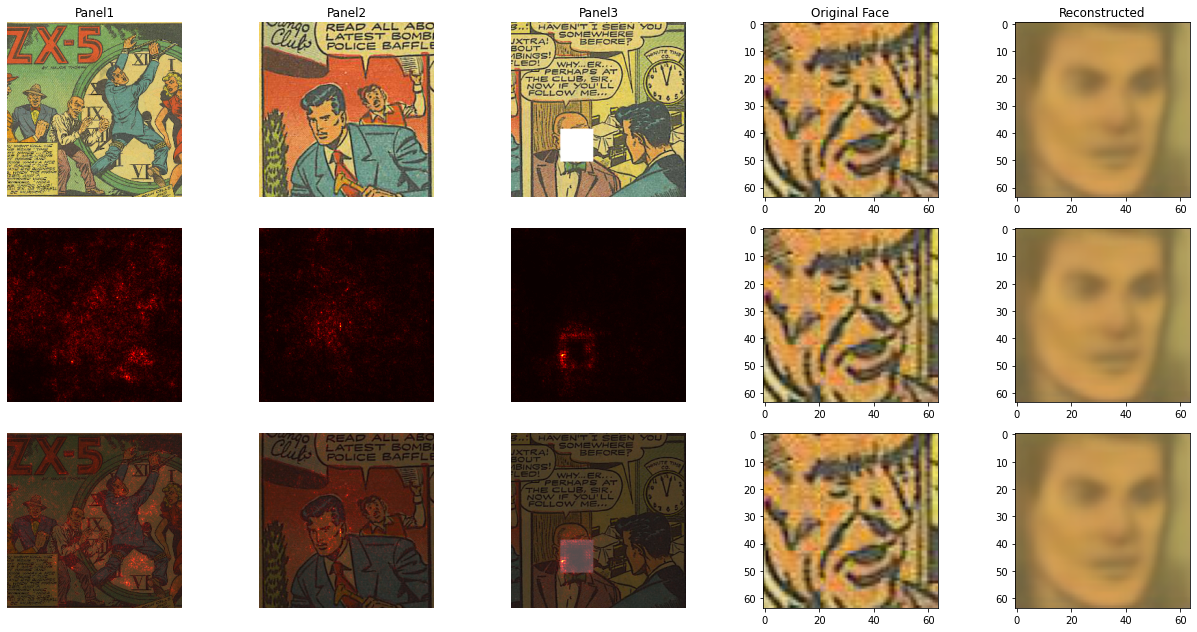

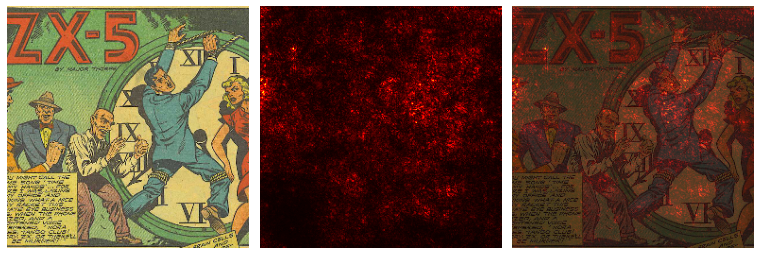

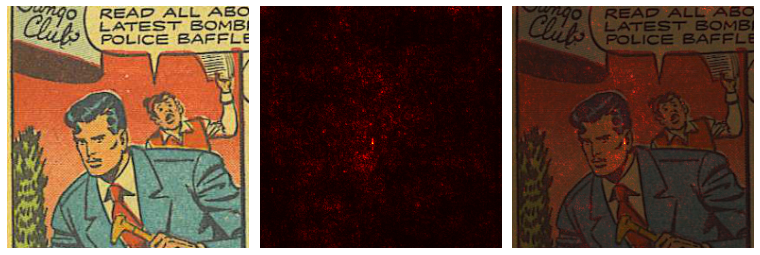

In [23]:
import copy

x, y, z, mask_coordinates = next(dl_iter)

draw_saliency(net, copy.deepcopy(x), copy.deepcopy(y))

draw_backbone_saliency(net.encoder.embedder, copy.deepcopy(x), 0)

draw_backbone_saliency(net.encoder.embedder, copy.deepcopy(x), 1)